In [1]:
!pip install rasterio
!pip install shapely
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
image_path = '../temp/sentinel2_visual_20220604.tif'
model_path = '../models/2025-08-13_16-02-25_fullaug_newdata_100.keras'

In [3]:
from tensorflow.keras.models import load_model

# Load the Keras model (ensure you have TensorFlow installed)
model = load_model(model_path)

2025-08-13 16:03:18.859132: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-13 16:03:18.865909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755126198.874535  215549 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755126198.877067  215549 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-13 16:03:18.885526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
import rasterio

# Open the GeoTIFF file
with rasterio.open(image_path) as src:
    # Read all bands (or select bands as needed)
    image = src.read()  # shape: (channels, height, width)
    transform = src.transform  # Affine transformation matrix
    crs = src.crs  # Coordinate Reference System

# Extract pixel resolution from the transform:
pixel_width = transform.a        # pixel size in x direction
pixel_height = -transform.e      # pixel size in y (use absolute value)

print(pixel_width, pixel_height)

10.0 10.0


In [5]:
import numpy as np
from tensorflow.keras.models import load_model
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters
patch_size = 128
threshold = 0.4  # adjust based on your model's calibration

# 1. Load the GeoTIFF
with rasterio.open(image_path) as src:
    # Read all bands; shape: (channels, height, width)
    image = src.read()
    transform = src.transform

# 2. Preprocess the Image
# Remove the batch dimension (if any) and adjust channels.
# Assuming your model was trained on the first 3 channels, drop the 4th channel.
# image currently has shape (4, H, W); we convert to (H, W, 3)
image = image[0:3, :, :]             # shape now (3, H, W)
image = np.transpose(image, (1, 2, 0)) # now shape: (H, W, 3)
H, W, _ = image.shape

# (Optional) Normalize the image if required by your model
# For example, if pixel values are in [0, 255]:
image = image / 255.0

# 4. Patchify the Image and Run Inference
# We'll process the image in non-overlapping patches of size 128x128
n_h = H // patch_size  # number of patches along height
n_w = W // patch_size  # number of patches along width

# Pre-allocate arrays for both versions
full_mask_thresholded = np.zeros((H, W), dtype=np.uint8)  # Binary mask
full_mask_probability = np.zeros((H, W), dtype=np.float32)  # Probability map

# Loop over patches, predict, and assemble both masks
for i in tqdm(range(n_h)):
    for j in range(n_w):
        # Extract patch
        patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size, :]

        # Expand dimensions to create a batch of one image
        patch_input = np.expand_dims(patch, axis=0)  # shape: (1, 128, 128, 3)

        # Run inference on the patch
        patch_pred = model.predict(patch_input, verbose = 0)
        patch_pred = np.squeeze(patch_pred)  # shape: (128, 128)

        # Store the raw probability values
        full_mask_probability[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch_pred

        # Convert prediction to binary mask using thresholding
        binary_patch = (patch_pred > threshold).astype(np.uint8)

        # Place the binary patch into the corresponding location in the thresholded mask
        full_mask_thresholded[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = binary_patch

print(f"Generated two versions:")
print(f"- Thresholded mask (binary): shape {full_mask_thresholded.shape}, dtype {full_mask_thresholded.dtype}")
print(f"- Probability mask (continuous): shape {full_mask_probability.shape}, dtype {full_mask_probability.dtype}")
print(f"- Probability range: {full_mask_probability.min():.3f} to {full_mask_probability.max():.3f}")

/home/yifan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
  0%|          | 0/85 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1755126204.282637  215680 service.cc:148] XLA service 0x7fb81c00dd70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755126204.282649  215680 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-08-13 16:03:24.290147: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1

Generated two versions:
- Thresholded mask (binary): shape (10980, 10980), dtype uint8
- Probability mask (continuous): shape (10980, 10980), dtype float32
- Probability range: 0.000 to 1.000


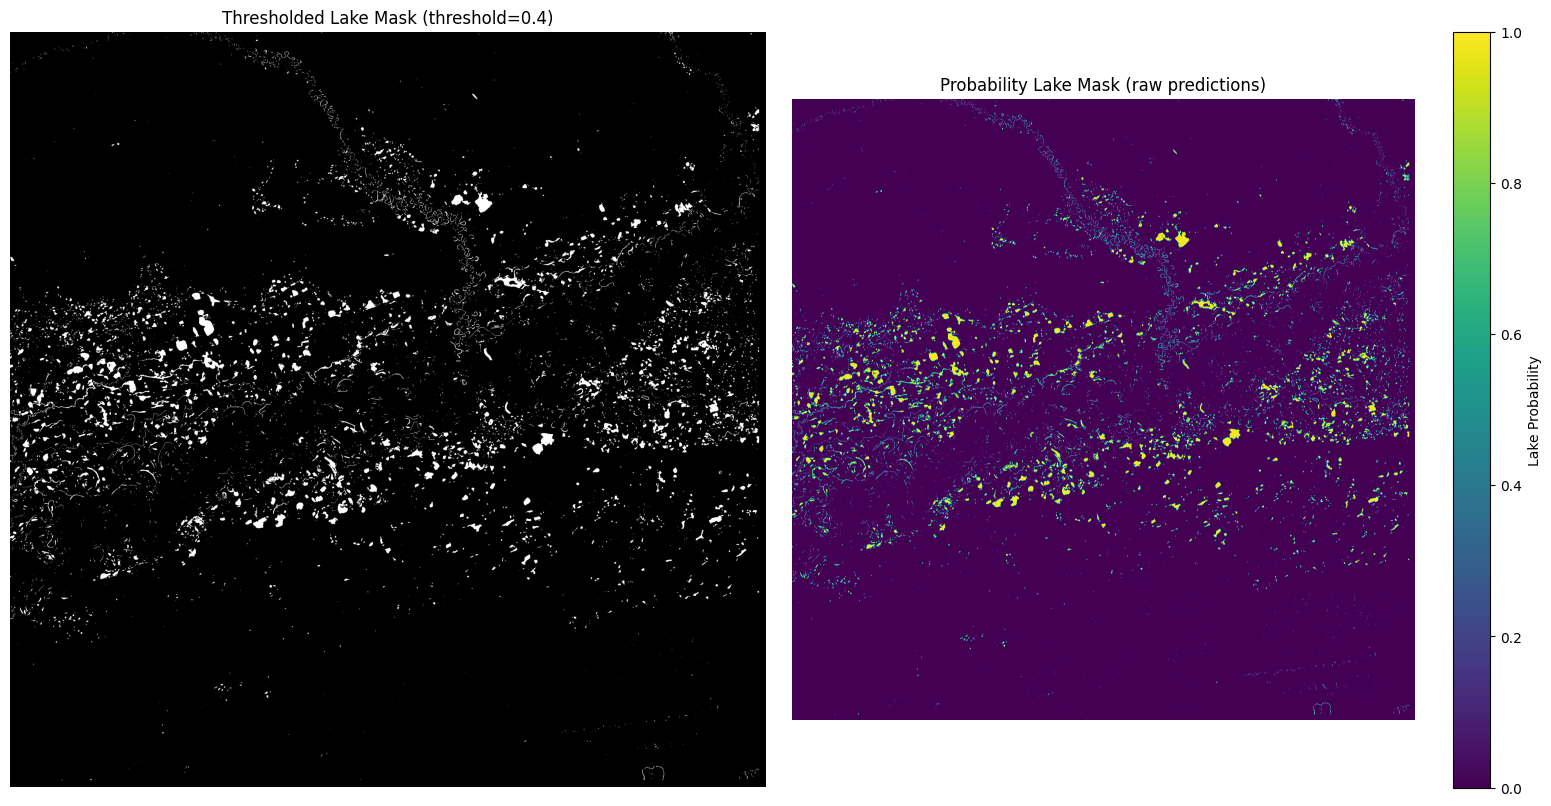

In [6]:
# 5. Visualize Both Versions of the Prediction
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Thresholded version (binary)
axes[0].imshow(full_mask_thresholded, cmap='gray')
axes[0].set_title(f"Thresholded Lake Mask (threshold={threshold})")
axes[0].axis('off')

# Probability version (continuous)
im = axes[1].imshow(full_mask_probability, cmap='viridis', vmin=0, vmax=1)
axes[1].set_title("Probability Lake Mask (raw predictions)")
axes[1].axis('off')

# Add colorbar for probability map
plt.colorbar(im, ax=axes[1], label='Lake Probability')

plt.tight_layout()
plt.show()

In [7]:
# Area calculations for THRESHOLDED version
binary_mask = full_mask_thresholded

print("Pixel width:", pixel_width)
print("Pixel height:", pixel_height)

pixel_area = pixel_width * pixel_height
print("Pixel area:", pixel_area)

total_pixels = binary_mask.size
print("Total number of pixels:", total_pixels)

lake_pixel_count = np.sum(binary_mask)
print("Number of lake pixels:", lake_pixel_count)

total_area = total_pixels * pixel_area
print("Total area:", total_area)

total_lake_area = lake_pixel_count * pixel_area
print("Total lake area:", total_lake_area)

non_lake_area= total_area - total_lake_area
print("Total non lake area:", non_lake_area, "square meters")

non_lake_pixel_count = total_pixels - lake_pixel_count
fraction_non_lake = non_lake_pixel_count / total_pixels
print("Fraction of area that is not lake:", fraction_non_lake)

Pixel width: 10.0
Pixel height: 10.0
Pixel area: 100.0
Total number of pixels: 120560400
Number of lake pixels: 3788326
Total area: 12056040000.0
Total lake area: 378832600.0
Total non lake area: 11677207400.0 square meters
Fraction of area that is not lake: 0.9685773603936284


In [8]:
from skimage.measure import label, regionprops
binary_mask = full_mask_thresholded  # Use the thresholded version for analysis
# Label connected regions in the binary mask (each region represents a separate lake)
labeled_mask = label(binary_mask)

# Get region properties for each lake
regions = regionprops(labeled_mask)

# Calculate and print area for each lake
for region in regions:
    lake_area = region.area * pixel_area
    print(f"Lake ID: {region.label}, Area: {lake_area:.2f} square meters")

Lake ID: 1, Area: 400.00 square meters
Lake ID: 2, Area: 1200.00 square meters
Lake ID: 3, Area: 9300.00 square meters
Lake ID: 4, Area: 12800.00 square meters
Lake ID: 5, Area: 3400.00 square meters
Lake ID: 6, Area: 2000.00 square meters
Lake ID: 7, Area: 1100.00 square meters
Lake ID: 8, Area: 11500.00 square meters
Lake ID: 9, Area: 900.00 square meters
Lake ID: 10, Area: 13300.00 square meters
Lake ID: 11, Area: 2000.00 square meters
Lake ID: 12, Area: 84500.00 square meters
Lake ID: 13, Area: 400.00 square meters
Lake ID: 14, Area: 300.00 square meters
Lake ID: 15, Area: 500.00 square meters
Lake ID: 16, Area: 4000.00 square meters
Lake ID: 17, Area: 100.00 square meters
Lake ID: 18, Area: 100.00 square meters
Lake ID: 19, Area: 100.00 square meters
Lake ID: 20, Area: 6600.00 square meters
Lake ID: 21, Area: 12400.00 square meters
Lake ID: 22, Area: 1100.00 square meters
Lake ID: 23, Area: 4500.00 square meters
Lake ID: 24, Area: 3000.00 square meters
Lake ID: 25, Area: 300.00 sq

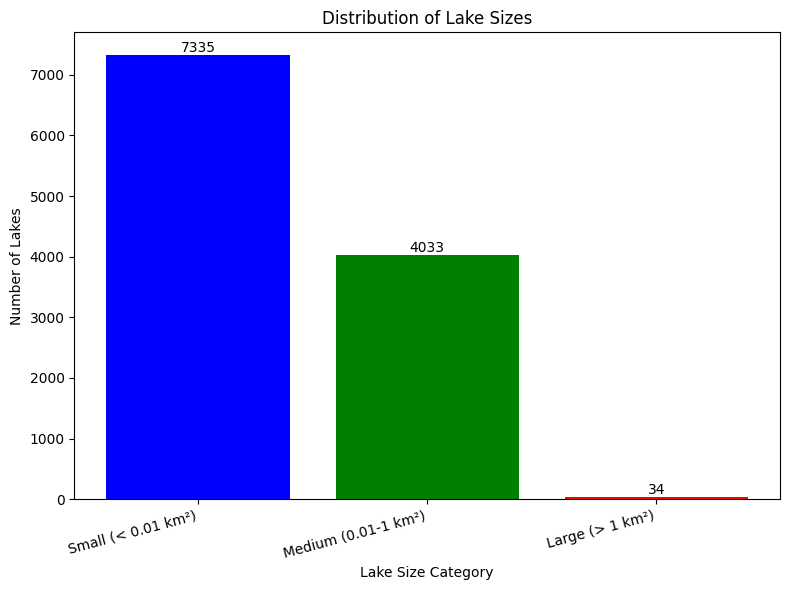

In [9]:
import numpy as np
import matplotlib.pyplot as plt

lake_categories = [
    {"name": "Small (< 0.01 km²)", "min_area": 0, "max_area": 10000, "color": "blue"},
    {"name": "Medium (0.01-1 km²)", "min_area": 10000, "max_area": 1000000, "color": "green"},
    {"name": "Large (> 1 km²)", "min_area": 1000000, "max_area": float('inf'), "color": "red"}
]

lake_counts = {category["name"]: 0 for category in lake_categories}

for region in regions:
    lake_area_m2 = region.area * pixel_area
    for category in lake_categories:
        if category["min_area"] <= lake_area_m2 < category["max_area"]:
            lake_counts[category["name"]] += 1
            break

categories = [category["name"] for category in lake_categories]
counts = [lake_counts[category] for category in categories]
colors = [category["color"] for category in lake_categories]

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=colors)
plt.xlabel("Lake Size Category")
plt.ylabel("Number of Lakes")
plt.title("Distribution of Lake Sizes")
plt.xticks(rotation=15, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [10]:
import rasterio
import os

# create /output folder if it doesn't exist
os.makedirs('../output', exist_ok=True)

# Save thresholded (binary) version
output_filename_thresholded = '../output/lakes_thresholded.tif'

with rasterio.open(
    output_filename_thresholded,
    'w',
    driver='GTiff',
    height=full_mask_thresholded.shape[0],
    width=full_mask_thresholded.shape[1],
    count=1,  # one band for the binary mask
    dtype=full_mask_thresholded.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(full_mask_thresholded, 1)  # Write the thresholded mask to band 1

print("Thresholded GeoTIFF saved as:", output_filename_thresholded)

# Save probability version
output_filename_probability = '../output/lakes_probability.tif'

with rasterio.open(
    output_filename_probability,
    'w',
    driver='GTiff',
    height=full_mask_probability.shape[0],
    width=full_mask_probability.shape[1],
    count=1,  # one band for the probability mask
    dtype=full_mask_probability.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(full_mask_probability, 1)  # Write the probability mask to band 1

print("Probability GeoTIFF saved as:", output_filename_probability)

Thresholded GeoTIFF saved as: ../output/lakes_thresholded.tif
Probability GeoTIFF saved as: ../output/lakes_probability.tif


In [11]:
import rasterio.features
from shapely.geometry import shape
import geopandas as gpd

# Generate GeoJSON from thresholded mask (binary lakes only)
# Extract polygons from the binary mask
# This will return all shapes (both 0 and 1 values), so we filter for lakes (value==1)
results = list(rasterio.features.shapes(full_mask_thresholded, transform=transform))
lake_polygons = [shape(geom) for geom, value in results if value == 1]

# Optionally, you can filter out very small polygons here if needed
# lake_polygons = [poly for poly in lake_polygons if poly.area > some_threshold]

# Create a GeoDataFrame with the same CRS as your original GeoTIFF
gdf = gpd.GeoDataFrame({'lake_id': range(1, len(lake_polygons) + 1),
                        'geometry': lake_polygons},
                       crs=crs)

# Save the GeoDataFrame to a GeoJSON file (from thresholded version)
output_geojson = "../output/lakes.geojson"
gdf.to_file(output_geojson, driver="GeoJSON")
print("Thresholded GeoJSON saved as:", output_geojson)

# Note: We don't create a GeoJSON from the probability mask since it's continuous values,
# but both TIFFs (thresholded and probability) are saved above for further analysis

Thresholded GeoJSON saved as: ../output/lakes.geojson


In [12]:
# Load the river dataset
river_path = "../temp/USA_Rivers_and_Streams-shp/9ae73184-d43c-4ab8-940a-c8687f61952f2020328-1-r9gw71.0odx9.shp"
rivers_gdf = gpd.read_file(river_path)

print(f"Rivers dataset loaded:")
print(f"- Number of river features: {len(rivers_gdf)}")
print(f"- Rivers CRS: {rivers_gdf.crs}")
print(f"- Rivers columns: {list(rivers_gdf.columns)}")
print(f"- Rivers bounds: {rivers_gdf.total_bounds}")

# Check if CRS matches our lakes
print(f"\nLakes CRS: {gdf.crs}")
print(f"CRS match: {rivers_gdf.crs == gdf.crs}")

# Preview first few rows of river data
print(f"\nFirst few river features:")
print(rivers_gdf.head())

Rivers dataset loaded:
- Number of river features: 112968
- Rivers CRS: EPSG:4326
- Rivers columns: ['OBJECTID', 'Name', 'Feature', 'State', 'Region', 'Miles', 'Shape__Len', 'geometry']
- Rivers bounds: [-172.78455892   17.95960621  -65.38756623   71.2253497 ]

Lakes CRS: PROJCS["WGS 84 / UTM zone 6N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32606"]]
CRS match: False

First few river features:
   OBJECTID            Name Feature State  Region  Miles  Shape__Len  \
0         1 

In [13]:
# Reproject rivers to match lakes CRS if needed
if rivers_gdf.crs != gdf.crs:
    print("Reprojecting rivers to match lakes CRS...")
    rivers_gdf = rivers_gdf.to_crs(gdf.crs)
    print(f"Rivers reprojected to: {rivers_gdf.crs}")

# Get the bounding box of our lakes to filter rivers to the study area
lakes_bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
print(f"Lakes bounds: {lakes_bounds}")

# Create a bounding box polygon for filtering
from shapely.geometry import box
study_area = box(*lakes_bounds)

# Filter rivers to only those that intersect with our study area
print("Filtering rivers to study area...")
rivers_in_area = rivers_gdf[rivers_gdf.intersects(study_area)]
print(f"Rivers in study area: {len(rivers_in_area)} (down from {len(rivers_gdf)})")

# Create a spatial index for faster intersection operations
print("Creating spatial index for rivers...")

Reprojecting rivers to match lakes CRS...
Rivers reprojected to: PROJCS["WGS 84 / UTM zone 6N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32606"]]
Lakes bounds: [ 399960. 7291240.  508760. 7400040.]
Filtering rivers to study area...
Rivers in study area: 221 (down from 112968)
Creating spatial index for rivers...


In [14]:
# Find lakes that overlap with rivers
print("Checking for lake-river overlaps...")

# Create a list to track which lakes overlap with rivers
lakes_overlapping_rivers = []

# Use spatial join to find overlaps (this is more efficient than checking each lake individually)
overlaps = gpd.sjoin(gdf, rivers_in_area, how='inner', predicate='intersects')

# Get unique lake IDs that overlap with rivers
overlapping_lake_ids = overlaps['lake_id'].unique()
print(f"Number of lakes overlapping with rivers: {len(overlapping_lake_ids)}")
print(f"Total lakes before filtering: {len(gdf)}")

# Create filtered datasets
# Lakes that do NOT overlap with rivers (the ones we want to keep)
lakes_no_rivers = gdf[~gdf['lake_id'].isin(overlapping_lake_ids)]
print(f"Lakes after excluding river overlaps: {len(lakes_no_rivers)}")

# Lakes that DO overlap with rivers (for analysis/visualization)
lakes_with_rivers = gdf[gdf['lake_id'].isin(overlapping_lake_ids)]
print(f"Lakes excluded due to river overlap: {len(lakes_with_rivers)}")

# Calculate area statistics
if len(lakes_no_rivers) > 0:
    remaining_area = lakes_no_rivers.geometry.area.sum()
    print(f"Total area of remaining lakes: {remaining_area:.2f} square units")

if len(lakes_with_rivers) > 0:
    excluded_area = lakes_with_rivers.geometry.area.sum()
    print(f"Total area of excluded lakes: {excluded_area:.2f} square units")

Checking for lake-river overlaps...
Number of lakes overlapping with rivers: 1031
Total lakes before filtering: 12025
Lakes after excluding river overlaps: 10994
Lakes excluded due to river overlap: 1031
Total area of remaining lakes: 306996100.00 square units
Total area of excluded lakes: 71836500.00 square units


/tmp/ipykernel_215549/1332600579.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend()
/tmp/ipykernel_215549/1332600579.py:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax2.legend()


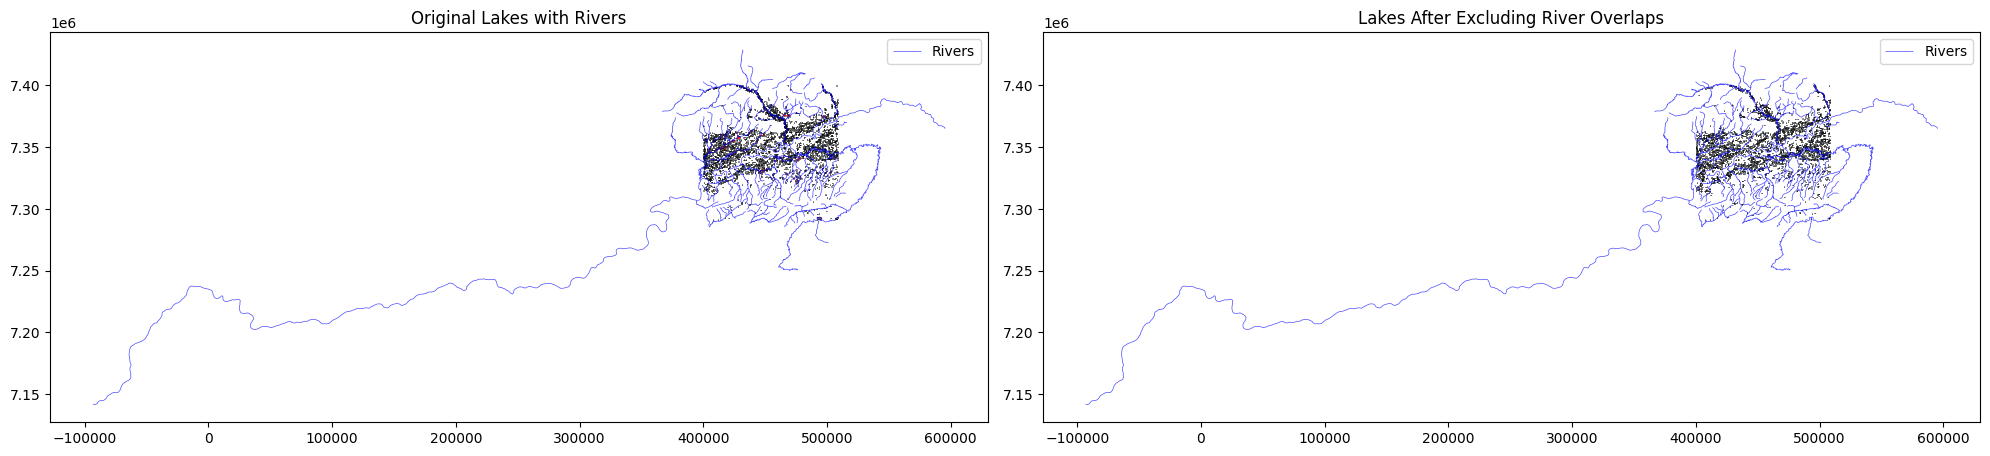

In [15]:
# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: All original lakes with rivers
ax1 = axes[0]
if len(rivers_in_area) > 0:
    rivers_in_area.plot(ax=ax1, color='blue', linewidth=0.5, alpha=0.7, label='Rivers')
gdf.plot(ax=ax1, color='lightblue', alpha=0.6, edgecolor='black', linewidth=0.5, label='All Lakes')
if len(lakes_with_rivers) > 0:
    lakes_with_rivers.plot(ax=ax1, color='red', alpha=0.8, label='Lakes overlapping rivers')
ax1.set_title('Original Lakes with Rivers')
ax1.legend()
ax1.set_aspect('equal')

# Plot 2: Filtered lakes (no river overlaps)
ax2 = axes[1]
if len(rivers_in_area) > 0:
    rivers_in_area.plot(ax=ax2, color='blue', linewidth=0.5, alpha=0.7, label='Rivers')
if len(lakes_no_rivers) > 0:
    lakes_no_rivers.plot(ax=ax2, color='lightblue', alpha=0.6, edgecolor='black', linewidth=0.5, label='Filtered Lakes')
ax2.set_title('Lakes After Excluding River Overlaps')
ax2.legend()
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

In [16]:
# Save the filtered dataset
print("Saving filtered lake dataset...")

# Save lakes without river overlaps as shapefile
if len(lakes_no_rivers) > 0:
    output_shapefile_filtered = "../output/lakes_no_rivers.geojson"
    lakes_no_rivers.to_file(output_shapefile_filtered, driver="GeoJSON")
    print(f"Filtered lakes shapefile saved as: {output_shapefile_filtered}")

# Summary statistics
print(f"\nSummary:")
print(f"- Original lakes: {len(gdf)}")
print(f"- Lakes excluded (river overlaps): {len(lakes_with_rivers)}")
print(f"- Final filtered lakes: {len(lakes_no_rivers)}")
print(f"- Percentage retained: {len(lakes_no_rivers)/len(gdf)*100:.1f}%")

Saving filtered lake dataset...
Filtered lakes shapefile saved as: ../output/lakes_no_rivers.geojson

Summary:
- Original lakes: 12025
- Lakes excluded (river overlaps): 1031
- Final filtered lakes: 10994
- Percentage retained: 91.4%
